In [1]:
from google.colab import drive
drive.mount('/content/drive')
# folder path
path='/content/drive/My Drive/ECSE 415/Assignment_2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Data**

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# create numpy array to store the image names and labels
image_names = np.empty((50,15), dtype='U25')
label = np.zeros((50,15))

# fill in names and labels
# labels are integer numbers
for i in range(0, 50):
  for j in range(0, 15):
    if(i < 9):
      if(j < 9):
        image_names[i,j] = "s0" + str(i+1) + "_0" + str(j+1) + ".jpg"
        label[i,j] = i+1
      else:
        image_names[i,j] = "s0" + str(i+1) + "_" + str(j+1) + ".jpg"
        label[i,j] = i+1
    else:
       if(j < 9):
        image_names[i,j] = "s" + str(i+1) + "_0" + str(j+1) + ".jpg"
        label[i,j] = i+1
       else:
        image_names[i,j] = "s" + str(i+1) + "_" + str(j+1) + ".jpg"
        label[i,j] = i+1



In [3]:
# convert 2D array into 1D
image_names = image_names.flatten()
label = label.flatten()
# array to store treated images
image = []
# resize images to 128 x 192
for name in image_names:
  img = cv2.imread(path + name).astype(np.float32) # BGR
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.resize(img, (128,192))
  image.append(img)

# split and random shuffle data
# library imported from sklearn
from sklearn.model_selection import train_test_split
image_train, image_test, label_train, label_test = train_test_split(image, label, test_size=0.20, shuffle=True)

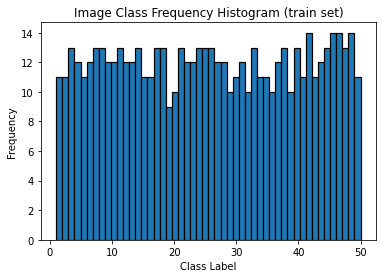

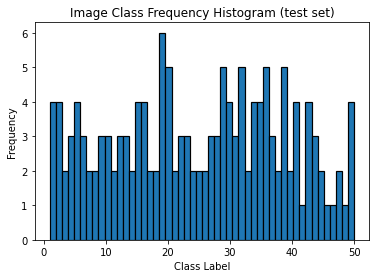

In [4]:
# frequency histograms of train and test labels
plt.hist(label_train, bins=50, edgecolor='black', linewidth=1.2)
plt.gca().set(title='Image Class Frequency Histogram (train set)', ylabel='Frequency', xlabel='Class Label')
plt.show()
plt.hist(label_test, bins=50, edgecolor='black', linewidth=1.2)
plt.gca().set(title='Image Class Frequency Histogram (test set)', ylabel='Frequency', xlabel='Class Label')
plt.show()

**2. Eigenface Representation**

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# define size of matrix D
M = len(image_train[0].flatten())
N = len(image_train)
D = np.empty((N, M))

# construct matrix D with all the images as points
for i in range(len(image_train)):
  D[i] = image_train[i].flatten()

# now D matrix becomes M x N size
D = D.T

# substract mean from matrix D before PCA
D_meaned = (D - np.mean(D, axis=1).reshape(-1,1))

# construct matrix C = D.T * D
C = D_meaned.T @ D_meaned


# Find Eigenvalues and Eigenvectors of matrix C
eig_val , eig_vec = np.linalg.eigh(C)

### code inspired from "ASK PYTHON" website 
# https://www.askpython.com/python/examples/principal-component-analysis
#sort the eigenvalues in descending order
sorted_index = np.argsort(eig_val)[::-1]
 
eig_val = eig_val[sorted_index]
#similarly sort the eigenvectors 
eig_vec = eig_vec[:,sorted_index]
# get eigenvectors of original space
# v = 1/lambda * (D@V)
eig_vec = D_meaned @ ((1 / eig_val) * eig_vec)
eig_vec = eig_vec.T
# normalize eigenvectors
for i in range(eig_vec.shape[0]):
  eig_vec[i] = eig_vec[i] / np.linalg.norm(eig_vec[i])
# bring back to original matrix dimension
eig_vec = eig_vec.T

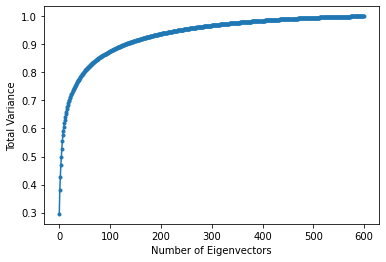

In [6]:
#### Code taken from tutorial 5
# Explained Variance Ratio
# 30 PCA dimensions (eigenvalues)
# eig_1, eig_2, eig_3, eig_4, ... 
# Explained_Variance_1 =  (eig_1) /(eig_1 + eig_2 + eig_3 + ... + eig_30)  
# Explained_Variance_2 =  (eig_1 + eig_2) / (eig_1 + eig_2 + eig_3 + ... + eig_30)  
# Explained_Variance_3 =  (eig_1 + eig_2 + eig_3) / (eig_1 + eig_2 + eig_3 + ... + eig_30)  
# .
# .
# .

plt.figure()
plt.plot(np.cumsum(eig_val) / np.sum(eig_val),'.-')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Total Variance')
plt.show()


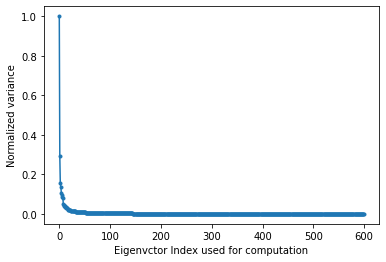

In [7]:
# code taken from tutorial 5
# Normalized Eigenvalues

normalized_eigenvalues = eig_val / eig_val.max()

plt.figure()
plt.plot(normalized_eigenvalues,'.-')
plt.xlabel('Eigenvctor Index used for computation')
plt.ylabel('Normalized variance')
plt.show()

From the "Total Variance vs Number of Eigenvectors" graph, we can see that the total variance reaches a plateau and approaches 1 asymptotically at around 80 eigenvectors. Similarly, from the "Normalized variance vs Eigenvectors" graph, the normalized variance approaches 0 aymptotically at around 80 eigenvectors. Thus, only around 80 eigenvectors is needed to represent the entire data.

In [8]:
# code inspired from tutorial 5
h, w = image_train[0].shape
n_components = 80
eig_vec_reduced = eig_vec[:,0:n_components].T
eigenfaces= eig_vec_reduced.reshape((n_components, h, w))

The first 5 eigenfaces: 


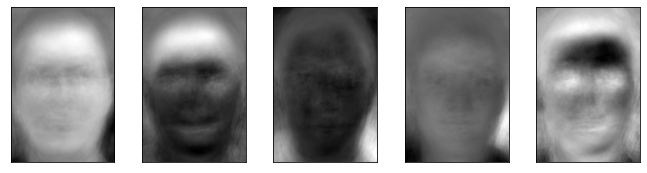

In [9]:
# code taken from tutorial 5
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, h, w, n_row=1, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

print("The first 5 eigenfaces: ")
plot_gallery(eigenfaces, h, w)
plt.show()

**3. Classification in Eigenspace**

In [10]:
# Find matches with Nearest Neighbour method
matches = 0
# iterate through all test images
for i in range(len(image_test)):
  # L2 distance
  L2_dist = np.linalg.norm(D.T - image_test[i].flatten(), axis=1)
  # index of minimum distance
  minimum = int(np.argmin(L2_dist))
  # append matches
  if(label_train[minimum] == label_test[i]):
    matches += 1
  
print("Accuracy with Nearest Neighbour method")
print( "with original high dimensional pixel space:")
print(str(round(matches/len(image_test)* 100, 2)) + " %")

Accuracy with Nearest Neighbour method
with original high dimensional pixel space:
76.0 %


In [11]:
# implementation based on Purdue paper
# https://engineering.purdue.edu/kak/computervision/ECE661_Fall2012/solution/hw9_s1.pdf
# define size of matrix D
m = len(image_test[0].flatten())
n = len(image_test)
Test = np.empty((n, m))

# construct matrix D with all the images as points
for i in range(len(image_test)):
  Test[i] = image_test[i].flatten()


# substract mean from matrix Test before PCA
Test_meaned = Test - np.mean(D, axis=1)

# array to store Test image projected to eigenspace
Test_eigenspace = np.zeros(Test.shape)
# project test images into eigenspace
for i in range(Test_meaned.shape[0]):
  # coefficient a
  a_test = np.zeros(eig_vec_reduced.shape[0])
  for j in range(eig_vec_reduced.shape[0]):
    a_test[j] = np.dot(Test_meaned[i], eig_vec_reduced[j])
  Test_eigenspace[i] = np.mean(D, axis=1) + a_test.T @ eig_vec_reduced





In [12]:
# the mean of training set
Train_meaned = (D - np.mean(D, axis=1).reshape(-1,1)).T

# project train images into eigenspace
Train_eigenspace = np.zeros(D.T.shape)

# similar idea to test set in previous code block
for i in range(Train_meaned.shape[0]):
  # coefficient a
  a_train = np.zeros(eig_vec_reduced.shape[0])
  for j in range(eig_vec_reduced.shape[0]):
    a_train[j] = np.dot(Train_meaned[i], eig_vec_reduced[j])
  Train_eigenspace[i] = np.mean(D, axis=1) + a_train.T @ eig_vec_reduced



In [13]:
# Find matches with Nearest Neighbour method
matches = 0
# iterate through all test images
for i in range(Test_eigenspace.shape[0]):
  # L2 distance
  L2_dist = np.linalg.norm(Train_eigenspace - Test_eigenspace[i], axis=1)
  # index of minimum distance
  minimum = int(np.argmin(L2_dist))
  # append matches
  if(label_train[minimum] == label_test[i]):
    matches += 1
  
print("Accuracy with Nearest Neighbour method")
print( "with Eigenspace:")
print(str(round(matches/Test_eigenspace.shape[0]* 100, 2)) + " %")

Accuracy with Nearest Neighbour method
with Eigenspace:
76.67 %


The accuracy of predicting test set images using Nearest Neighbour method on the training set is 76.0% in the original high dimensional pixel space, and 76.67% in the eigenspace. We can see that there is only a 1% discrepancy between predictions using orignal space and eigenspace, and the prediction using eigenspace is better. This small difference can be expected as the images are projected into the reduced eigenspace, only the most important features are kept, thus reducing noises in the image. There should not be a very significant difference in accuracy between both original space and eigenspace.

In [14]:
# Linear SVM Classifier from sklearn
from sklearn import svm
import matplotlib.pyplot as plt

# code inspired from tutorial 6 and sklearn website
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
clf = svm.LinearSVC(C=0.1)
clf.fit(Train_eigenspace, label_train)
print("The accuracy using SVM classifier: ")
print(clf.score(Test_eigenspace, label_test)*100)

The accuracy using SVM classifier: 
80.0


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


The linear SVM classifier's accuracy is slightly better (around 3-5 %) than the Nearest Neighbour classifer's accuracy.

In [15]:
# RBF SVM Classifier from sklearn
clf_rbf = svm.SVC(gamma='scale',C = 10., kernel='rbf')
clf_rbf.fit(Train_eigenspace, label_train)
print("The accuracy using RBF SVM classifier: ")
print(clf_rbf.score(Test_eigenspace, label_test)*100)

The accuracy using RBF SVM classifier: 
85.33333333333334


The RBF SVM classifier's accuracy is the best one out of all the classifiers. It has an accuracy a lot better (8-10%)  than the Nearest Neighbour classifier's accuracy.

In [16]:
# Random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier(n_estimators=300, max_depth=10, criterion='entropy')
clf_forest.fit(Train_eigenspace, label_train)
print("The accuracy using Random Forests classifier: ")
print(clf_forest.score(Test_eigenspace, label_test)*100)

The accuracy using Random Forests classifier: 
82.0


The Random Forests classifier's accuracy is also a very good classifer. It has an accuracy a lot better (5-8%)  than the Nearest Neighbour classifier's accuracy.

In [17]:
# Per class accuracy for RBF SVM Classifier
from sklearn.metrics import confusion_matrix

# code inspired from Reference
#https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
label_pred = clf_rbf.predict(Test_eigenspace)
cm = confusion_matrix(label_test, label_pred, labels = clf_rbf.classes_)

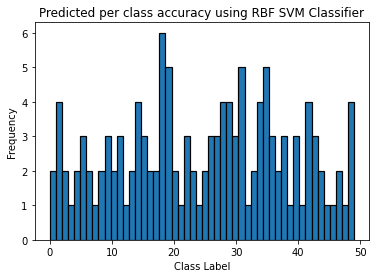

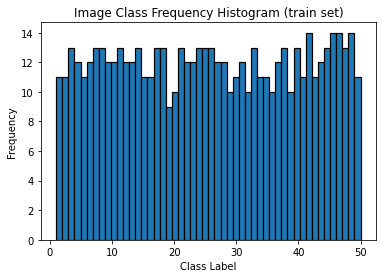

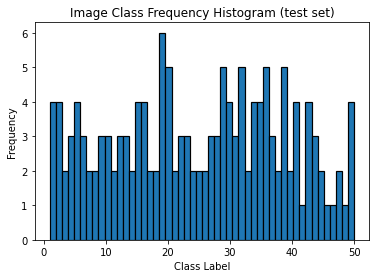

In [18]:
perClass_accuracy = []
for i in range(cm.shape[0]):
  for j in range(cm[i][i]):
    perClass_accuracy.append(i)

# frequency histograms of per class accuracy
plt.hist(perClass_accuracy, bins=50, edgecolor='black', linewidth=1.2)
plt.gca().set(title='Predicted per class accuracy using RBF SVM Classifier', ylabel='Frequency', xlabel='Class Label')
plt.show()
# frequency histograms of train and test labels
plt.hist(label_train, bins=50, edgecolor='black', linewidth=1.2)
plt.gca().set(title='Image Class Frequency Histogram (train set)', ylabel='Frequency', xlabel='Class Label')
plt.show()
plt.hist(label_test, bins=50, edgecolor='black', linewidth=1.2)
plt.gca().set(title='Image Class Frequency Histogram (test set)', ylabel='Frequency', xlabel='Class Label')
plt.show()

The per-class accuracy histogram by RBF SVM looks very different to the training dataset and looks very similar to the testing dataset. There is no clear correlation between per-class accuracy histogram and training dataset histogram. However, there is a clear correlation between the per-class accuracy histogram and the testing dataset. In fact, the shape of both per-class and testing histograms look very similar and the range for frequency values are the same. The peaks in both per-class and testing histograms also appear at similar class labels.

**4. Face Detection**

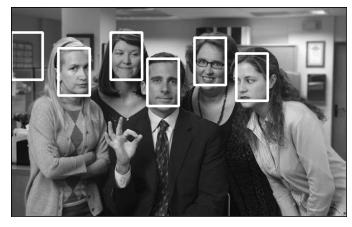

In [28]:
# reduce the eigenspace to find only the most key features
n_components = 7
eig_vec_reduced = eig_vec[:,0:n_components].T
# Face detection with PCA
# reading group image
img = cv2.imread(path + 'group_image.jpg') # BGR
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float64)
# h,w are the bounding box params
h = 90
w = 60
# set threshold
threshold = 5300
# mean image
mean = np.mean(D, axis=1).reshape(-1,1)

# iterate through the group image with bounding box, steps of 10 pixels
### important assumption ###
# Anything past the top 1/3 of the image is not considered as a face
# this is a fait assumption since the head is only taking around 1/4 
# of a human's body length, this is applicable to images with entire human
# body structures
### start x and y at (0,50) to boost the algorithm's speed
# top corner will probably not have a face in it anyway
for j in range(50, (int(img.shape[0]) - 250), 10):
  for i in range(0, (int(img.shape[1]) - w), 10):
    x = i 
    y = j 
    # bounding box's sub image, resized to 128x129
    # to match training set image
    sub_img = img[y:y+h, x:x+w]
    sub_img = cv2.resize(sub_img, (128,192))
    sub_img = sub_img.flatten().reshape(-1,1)
    sub_img_meaned = (sub_img - mean).T
  
    # coefficient a
    a_sub = np.zeros(eig_vec_reduced.shape[0])
    for k in range(eig_vec_reduced.shape[0]):
      a_sub[k] = np.dot(sub_img_meaned, eig_vec_reduced[k])
    # reconstruction & map sub image to eigenspace
    sub_img_eig = mean + (a_sub.T @ eig_vec_reduced).reshape(-1,1)

    # reconstruction error
    distance = np.linalg.norm(sub_img - sub_img_eig)

    # draw box if face
    if(distance < threshold):
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)

# plot the image with face detected in bounding boxes
plt.imshow(img, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()
 




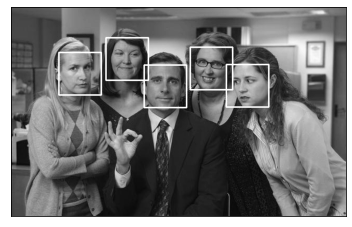

In [20]:
# code taken from tutorial 5
# Viola_Jones algorithm
import numpy as np
import cv2
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

# reading group image
img = cv2.imread(path + 'group_image.jpg') # BGR
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# detecMutliScale
#   Params: image – Matrix of the type CV_8U containing an image where objects are detected.
#           scaleFactor (1.1) – Parameter specifying how much the image size is reduced at each image scale.
#           minNeighbors (3) – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
#           minSize (0,0) – Minimum possible object size. Objects smaller than that are ignored.
#           maxSize (0,0) – Maximum possible object size. Objects larger than that are ignored.

# 1.5 scaleFactor for best performance
faces = face_cascade.detectMultiScale(gray, 1.5, 2)

for (x,y,w,h) in faces:
    gray = cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(gray, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()

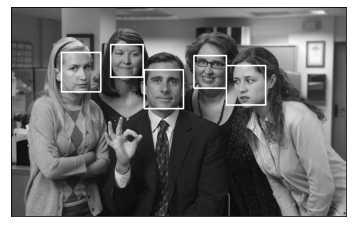

In [21]:
# Face detector using Hog
# code taken from techtutorialsx
# https://techtutorialsx.com/2021/04/06/python-dlib-face-detection/
import dlib
import cv2
import matplotlib.pyplot as plt

# helper method to extract bounding box, code taken from
# https://pyimagesearch.com/2021/04/19/face-detection-with-dlib-hog-and-cnn/
def convert_and_trim_bb(image, rect):
	# extract the starting and ending (x, y)-coordinates of the
	# bounding box
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()

	# ensure the bounding box coordinates fall within the spatial
	# dimensions of the image
	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])

	# compute the width and height of the bounding box
	w = endX - startX
	h = endY - startY

	# return our bounding box coordinates
	return (startX, startY, w, h)
 
img = cv2.imread(path + 'group_image.jpg') # BGR
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
detector = dlib.get_frontal_face_detector()
face = detector(gray, 1)
boxes = [convert_and_trim_bb(gray, r) for r in face]

for (x,y,h,w) in boxes:
  gray = cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(gray, cmap='gray')
plt.xticks(())
plt.yticks(())
plt.show()


**4.4 Comparisons**

In 4.1 Face Detection using PCA, the number of true positives are 5, false positive 1, and false negative 0. Note that this amazing performance is only obtained after reducing the n_components of PCA to 7 (only the key features of a face are considered) and by making a reasonable assumption that anything below 1/3 of image height will not be a face. Since PCA is not scale invariant, picking the right sized bounding box is very important if we want an reconstruction image to match the ones in the training set. More training data may be needed to improve the. PCA classifier's performance. In 4.2 Viola-Jones and in 4.3 Hog Face detectoion, both have 5 true positives, 0 false positive, and 0 false negative. This is amazing performance obtained by tuning the various parameters.

Viola-Jones classifier is scale-invariant, whereas PCA is not. Therefore, if the faces within an image have very different scales, Viola-Jones face detector will most likely outperform PCA detector. In addition, PCA would not work if there are outliers in the image, if the face is occluded, if the face has intense lighitng variation. I concluded Viola Jones work better than PCA.

Similarly, Hog detector is not scale-invariant, it will not perform well if all the faces within an image have different scales. In addition, it would also perform poorly against different oriented faces (ie. turned/tilted faces).

